In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv
import scipy.io as sio
from scipy import stats
import glob
import sys
import os


%load_ext autoreload
%autoreload 1
%aimport CybergloveMethods

# Can hand augmeentation change the way wee use our hands?

To assess the changes in finger coordination, we tracked the kinematics of the augmented (right) hand of peoplle training to use the Third Thumb. To this extent, we have used flex sensors embedded in a dataglove (CyberGlove, Virtual Technologies, Palo Alto, CA, USA). Data was sampled continuously at 100 Hz using Shadow Robot’s CyberGlove interface for the Robot Operating System.

This noteebook is used for **data extraction**, **eda** and **pre-preocessing** on an individual participant level. Group-level analyses can be found in the separate notebooks.


In [2]:
path = '/Users/paulina/Desktop/Studies/Cyberglove/'
subjects = np.sort([os.path.basename(x) for x in glob.glob(path + '/SF*')])
subjects

array(['SF11', 'SF12', 'SF13', 'SF14', 'SF15', 'SF16', 'SF17', 'SF19',
       'SF21', 'SF22', 'SF23', 'SF24', 'SF5', 'SF6', 'SF7', 'SF8'],
      dtype='<U4')

### Read in the data

Due to acquisition errors, for 2 augmentation participants and 2 control participants, the data recorded during the first day of training was unavailable. Therefore, for these participants, the data from the second day of training was used instead. Similarly, when the data from the last day of training was unavailable (3 augmentation participants, 2 control participants), the data from the penultimate day of training was used instead. Furthermore, if a participant took a break during the training session (e.g. to go to the toilet), additional calibration file was recorded.

In [3]:
subj = subjects[7]
subj

'SF19'

In [4]:
day1 = str(1) # first day
day5 = str(5) # last day

calibFile1 = path + subj + '/D' + day1 + '/calib/' + subj +'-D' + day1 + '-mainCalib'
calibFile2 = path + subj + '/D' + day1 +'/calib/' + subj +'-D' + day1 + '-mainCalib2'
calibFile5 = path + subj + '/D' + day5 + '/calib/' + subj + '-D' + day5 + '-mainCalib'
calibFile6 = path + subj + '/D' + day5 + '/calib/' + subj + '-D' + day5 + '-mainCalib2'

if os.path.isfile(calibFile2):
    print("D1: 2 calibration files found") 
if os.path.isfile(calibFile6):
    print("D5: 2 calib files")
    
rawFiles1 = np.sort(glob.glob(path + subj + '/D' + day1 + '/*.csv'))
rawFiles5 = np.sort(glob.glob(path + subj + '/D' + day5 + '/*.csv'))

### Pre-processing

Recorded data from the 19 sensors is calibrated using the recorded mapping from the sensor-values to the joint angles. The joint angles are then smoothed using a 3rd order Savitzky-Golay filter, with a window length of 151 samples. Finally, to account for different range of motion of different fingers, angular velocities are calculated as the first difference of the filtered joint angle data divided by the time step.


In [5]:
# Clear previously created objects 
CG1 = None
CG2 = None
CG5 = None
CG6 = None

CG1 = [CybergloveMethods.CyberGloveSample(calibFile1, file) for file in rawFiles1[0:]]
#CG2 = [CybergloveMethods.CyberGloveSample(calibFile2, file) for file in rawFiles1[5:]]
CG5 = [CybergloveMethods.CyberGloveSample(calibFile5, file) for file in rawFiles5[0:]]
#CG6 = [CybergloveMethods.CyberGloveSample(calibFile6, file) for file in rawFiles5[5:]]

In [6]:
# Concatenate all tasks

allVel1 = {}
allFilteredData1 = {}
allRawData1 = {}
allVel5 = {}
allFilteredData5 = {}
allRawData5 = {}


# D1
for d in CG1:
    for v in d.Vel.keys():
        allVel1.setdefault(v,[]).extend(d.Vel[v])
        allFilteredData1.setdefault(v,[]).extend(d.FilteredData[v])
        allRawData1.setdefault(v,[]).extend(d.RawData[v])
        

if CG2 is not None:
    for d in CG2:
        for v in d.Vel.keys():
            allVel1.setdefault(v,[]).extend(d.Vel[v])
            allFilteredData1.setdefault(v,[]).extend(d.FilteredData[v])
            allRawData1.setdefault(v,[]).extend(d.RawData[v])
            
# D5
for d in CG5:
    for v in d.Vel.keys():
        allVel5.setdefault(v,[]).extend(d.Vel[v])
        allFilteredData5.setdefault(v,[]).extend(d.FilteredData[v])
        allRawData5.setdefault(v,[]).extend(d.RawData[v])
        

if CG6 is not None:
    for d in CG6:
        for v in d.Vel.keys():
            allVel5.setdefault(v,[]).extend(d.Vel[v])
            allFilteredData5.setdefault(v,[]).extend(d.FilteredData[v])
            allRawData5.setdefault(v,[]).extend(d.RawData[v])
            
            
sio.savemat(path + subj + '/data.mat',{'allFilteredData1': allFilteredData1, 'allFilteredData5': allFilteredData5, 'allVel1': allVel1, 'allVel5': allVel5})

## Basic EDA

Let's check how our raw, calibrated and filtered data looks like

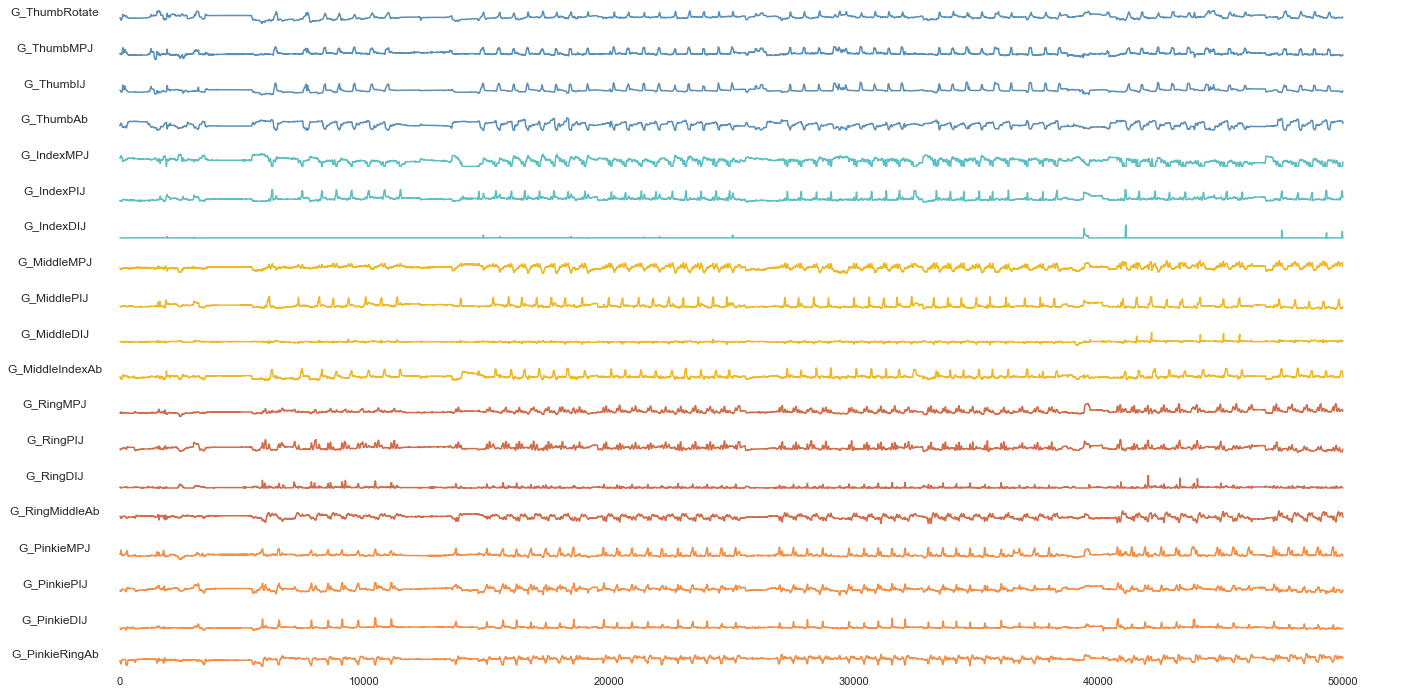

In [19]:
CGrawdata1 = pd.DataFrame.from_dict(allRawData1)

colors = ['#5a8fb6','#5a8fb6','#5a8fb6', '#5a8fb6', # thumb
          '#5dbfc1', '#5dbfc1', '#5dbfc1', # index
          '#ecb925', '#ecb925', '#ecb925', '#ecb925', # middle
          '#d06c49', '#d06c49', '#d06c49', '#d06c49', # ring
          '#f28e45', '#f28e45', '#f28e45', '#f28e45'] # pinkie
i = 0
pal = {}
for feature in CGrawdata1.iloc[:,0:-3].columns:
    pal[feature] = colors[i]
    i = i+1

f, axes = plt.subplots(19, 1, figsize=(20,10), sharex=True)
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "lines.linewidth": 1.5, 'font.size': 20})
for ax, feature in zip(axes.flat, CGrawdata1.iloc[:,0:-3].columns):
    sns.lineplot(data=CGrawdata1[feature][0:50000], ax=ax, color=pal[feature], palette=[pal[feature]])
    sns.despine(bottom=True, left=True, right=True, top=True)
    ax.set(yticks=[])
    #ax.set(xlabel=None)
    ax.set_ylabel(feature, rotation=0)
plt.tight_layout()

We can see that Index_DIJ sensor is malfuctioning (is off), as it does not seem to contain any reliable signal. 

Let's focus on the PIJ joints and zoom in on a fragment of the first task (SFO) and see whether we can see a pattern corresponding to finger opposition, and how does it look after calibration and smoothing.

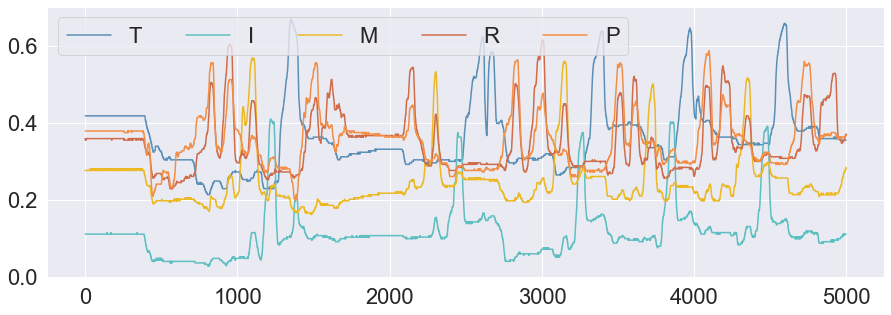

In [32]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,5))
plt.plot(CG1[0].RawData['G_ThumbIJ'][5000:10000], color='#5a8fb6')
plt.plot(CG1[0].RawData['G_IndexPIJ'][5000:10000], color='#5dbfc1')
plt.plot(CG1[0].RawData['G_MiddlePIJ'][5000:10000], color='#ecb925')
plt.plot(CG1[0].RawData['G_RingPIJ'][5000:10000], color='#d06c49')
plt.plot(CG1[0].RawData['G_PinkiePIJ'][5000:10000], color='#f28e45')
plt.legend(['T','I','M','R','P'],loc='best',ncol=5)

In the raw data we can see big baselline differences between the fingers. It's a bit tricky to see in which order the finger were opposed to the Third Thumb. Let's see how does the same data look after calibration.

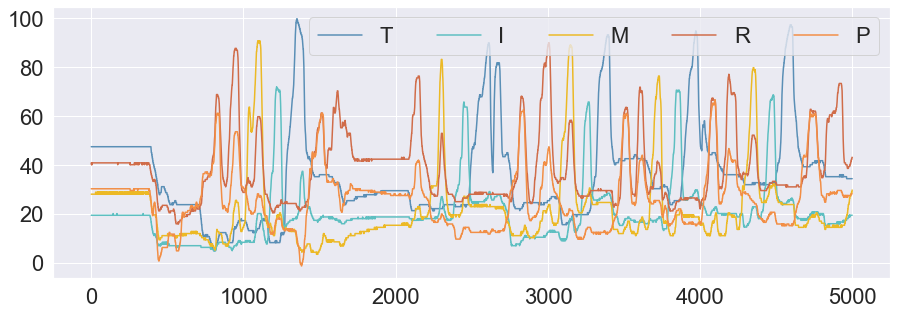

In [33]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,5))
plt.plot(CG1[0].CalibratedData['G_ThumbIJ'][5000:10000], color='#5a8fb6')
plt.plot(CG1[0].CalibratedData['G_IndexPIJ'][5000:10000], color='#5dbfc1')
plt.plot(CG1[0].CalibratedData['G_MiddlePIJ'][5000:10000], color='#ecb925')
plt.plot(CG1[0].CalibratedData['G_RingPIJ'][5000:10000], color='#d06c49')
plt.plot(CG1[0].CalibratedData['G_PinkiePIJ'][5000:10000], color='#f28e45')
plt.legend(['T','I','M','R','P'],loc='best',ncol=5)

In calibrated data we still have quite some baseline differences (potentially due to naturall poosture of the hand), but the data is a bit more readible. It's now easier to see that the SFO task was done in the pinkie-ring-middle-index-thumb order.

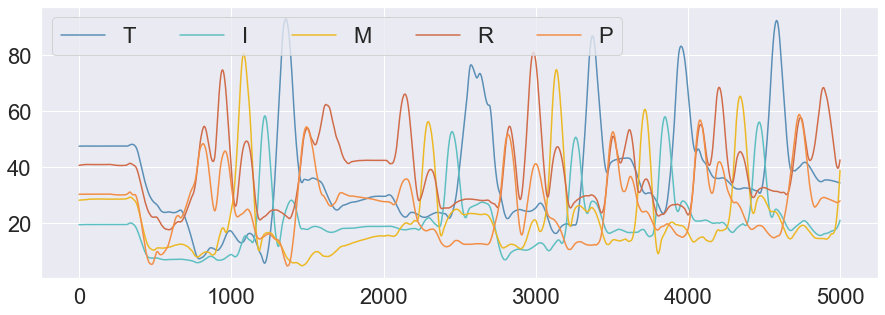

In [35]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,5))
plt.plot(CG1[0].FilteredData['G_ThumbIJ'][5000:10000], color='#5a8fb6')
plt.plot(CG1[0].FilteredData['G_IndexPIJ'][5000:10000], color='#5dbfc1')
plt.plot(CG1[0].FilteredData['G_MiddlePIJ'][5000:10000], color='#ecb925')
plt.plot(CG1[0].FilteredData['G_RingPIJ'][5000:10000], color='#d06c49')
plt.plot(CG1[0].FilteredData['G_PinkiePIJ'][5000:10000], color='#f28e45')
plt.legend(['T','I','M','R','P'],loc='best',ncol=5)

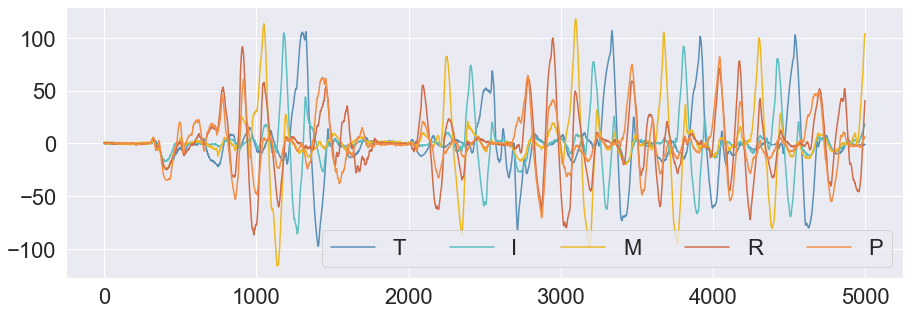

In [36]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,5))
plt.plot(CG1[0].Vel['G_ThumbIJ'][5000:10000], color='#5a8fb6')
plt.plot(CG1[0].Vel['G_IndexPIJ'][5000:10000], color='#5dbfc1')
plt.plot(CG1[0].Vel['G_MiddlePIJ'][5000:10000], color='#ecb925')
plt.plot(CG1[0].Vel['G_RingPIJ'][5000:10000], color='#d06c49')
plt.plot(CG1[0].Vel['G_PinkiePIJ'][5000:10000], color='#f28e45')
plt.legend(['T','I','M','R','P'],loc='best',ncol=5)

## PIJ

Let's focus on the PIJ joints and compute the kinematic matrices and finger independence for this participant.

In [37]:
Beta1, R1 = CybergloveMethods.LinRegression(allVel1, 'PIJ')
Beta5, R5 = CybergloveMethods.LinRegression(allVel5, 'PIJ')

[Text(0, 0.5, 'T'),
 Text(0, 1.5, 'I'),
 Text(0, 2.5, 'M'),
 Text(0, 3.5, 'R'),
 Text(0, 4.5, 'P')]

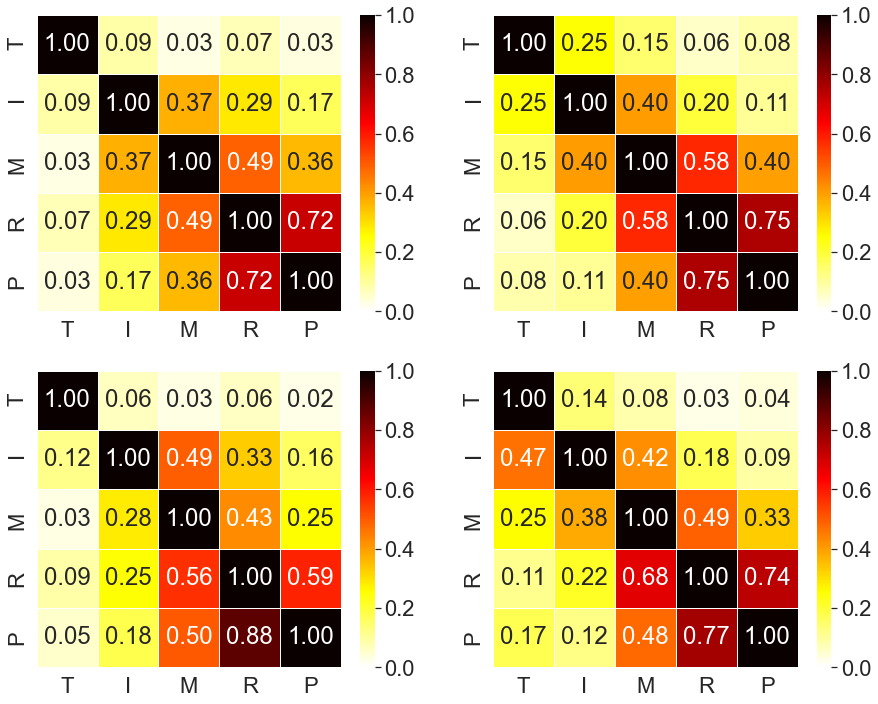

In [39]:
sns.set(font_scale = 2)
plt.figure(figsize=(15, 12))
fin_label = ['T','I','M','R','P']

ax1 = plt.subplot(221)
ax1 = sns.heatmap(R1, annot=True, linewidths=.5, fmt='.2f',cmap= 'hot_r', vmin=0,vmax=1)
ax1.set_xticklabels(fin_label)
ax1.set_yticklabels(fin_label)

ax2 = plt.subplot(222)
ax2 = sns.heatmap(R5, annot=True, linewidths=.5, fmt='.2f',cmap= 'hot_r',vmin=0,vmax=1)
ax2.set_xticklabels(fin_label)
ax2.set_yticklabels(fin_label)

ax3 = plt.subplot(223)
ax3 = sns.heatmap(Beta1, annot=True, linewidths=.5, fmt='.2f',cmap= 'hot_r', vmin=0,vmax=1)
ax3.set_xticklabels(fin_label)
ax3.set_yticklabels(fin_label)

ax4 = plt.subplot(224)
ax4 = sns.heatmap(Beta5, annot=True, linewidths=.5, fmt='.2f',cmap= 'hot_r',vmin=0,vmax=1)
ax4.set_xticklabels(fin_label)
ax4.set_yticklabels(fin_label)

In [40]:
Ind1 = CybergloveMethods.MultRegression(allVel1, 'PIJ')
Ind5 = CybergloveMethods.MultRegression(allVel5, 'PIJ')
independ = np.vstack((Ind1, Ind5))
independ

array([[0.01132378, 0.16235745, 0.30081518, 0.58573737, 0.51563388],
       [0.07320916, 0.20350748, 0.42238878, 0.66154639, 0.57413767]])

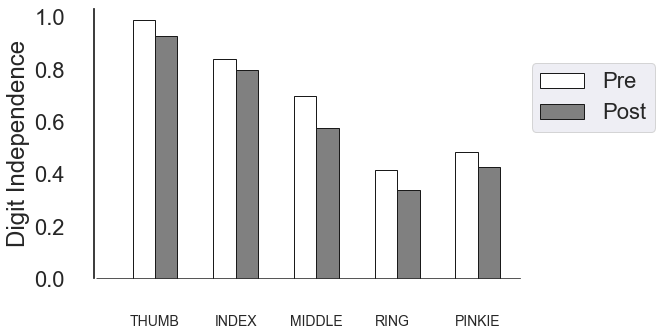

In [41]:
sns.set(font_scale = 2)
width = 0.25 
error_kw = {'capsize': 10, 'capthick': 1, 'ecolor': 'black', 'linewidth': 1}
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(0.55, 1-independ[0][0], width, alpha=1, color='white', edgecolor='k', linewidth=1) 
plt.bar(0.8, 1-independ[1][0], width, alpha=1, color='grey', edgecolor='k', linewidth=1) 
plt.bar(1.45, 1-independ[0][1], width, alpha=1, color='white', edgecolor='k', linewidth=1) 
plt.bar(1.7, 1-independ[1][1], width, alpha=1, color='grey', edgecolor='k', linewidth=1) 
plt.bar(2.35, 1-independ[0][2], width, alpha=1, color='white', edgecolor='k', linewidth=1) 
plt.bar(2.60, 1-independ[1][2], width, alpha=1, color='grey', edgecolor='k', linewidth=1) 
plt.bar(3.25, 1-independ[0][3], width, alpha=1, color='white', edgecolor='k', linewidth=1) 
plt.bar(3.5, 1-independ[1][3], width, alpha=1, color='grey', edgecolor='k', linewidth=1)
plt.bar(4.15, 1-independ[0][4], width, alpha=1, color='white', edgecolor='k', linewidth=1) 
plt.bar(4.4, 1-independ[1][4], width, alpha=1, color='grey', edgecolor='k', linewidth=1) 

# Set the y axis label
ax.set_ylabel('Digit Independence')

# Set the position of the x ticks
ax.set_xticks([0.675, 1.575, 2.475, 3.325, 4.275])

# Set the labels for the x ticks
ax.set_xticklabels(["THUMB","INDEX","MIDDLE","RING","PINKIE"])
ax.tick_params(axis='x', pad=30, labelsize=14)
# Add gridline
#ax.grid(color='k', linestyle='--', linewidth=0.5, axis ='y', which="both")
ax.set_facecolor('xkcd:white')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Pre','Post'], loc='lower left', bbox_to_anchor=(1, 0.5))
ax.axhline(0, xmin=0.05, color="black")
ax.axvline(0, color="black")
plt.show()

In [17]:
sio.savemat(path + subj + '/Matrices-PIJ.mat',{'R1': R1, 'R5': R5, 'Beta1' : Beta1, 'Beta5': Beta5, 'Multi' : independ})

## PCA

Finally, to quantify the complexity of the hand movements, let's use the Principal Components Analysis (PCA) of the angular velocities of the PIP joints. Prior to PCA, the angular velocities are z-normalised, note however that similar results were obtained with not normalised data. The extracted principal components (PCs) are ordered according to the amount of variance explained by each component. 

In [45]:
PIJvel1 = {}
PIJvel5 = {}
scaled_PIJvel1 = {}
scaled_PIJvel5 = {}

PIJvel1['cumVar'], PIJvel1['loadings']  = CybergloveMethods.kinPCA(allVel1, 'PIJ', 0)
PIJvel5['cumVar'], PIJvel5['loadings'] = CybergloveMethods.kinPCA(allVel5, 'PIJ', 0)
scaled_PIJvel1['cumVar'], scaled_PIJvel1['loadings'] = CybergloveMethods.kinPCA(allVel1, 'PIJ', 1)
scaled_PIJvel5['cumVar'], scaled_PIJvel5['loadings'] = CybergloveMethods.kinPCA(allVel5, 'PIJ', 1)


Text(0, 0.5, 'Cumulative Variance')

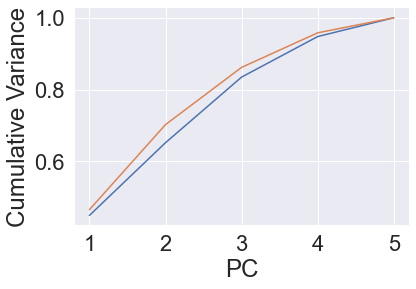

In [46]:
plt.plot(scaled_PIJvel1['cumVar'])
plt.plot(scaled_PIJvel5['cumVar'])
sns.despine(right=True, top=True)
sns.set(style="white", font_scale=2, rc={"axes.facecolor": (0, 0, 0, 0), "lines.linewidth": 1.5})
plt.xticks([0,1,2,3,4], labels=[1,2,3,4,5])
plt.xlabel('PC')
plt.ylabel('Cumulative Variance')

In [48]:
sio.savemat(path + subj + '/PCA.mat',{'PIJvel1': PIJvel1, 'PIJvel5': PIJvel5, 
                                    'scaled_PIJvel1': scaled_PIJvel1, 'scaled_PIJvel5': scaled_PIJvel5})